# **FinQuery: Intelligent Banking Intent Classification for Customer Support**

# BUSINESS UNDERSTANDING

- I aim to build a robust intent-classification model for BANKING77, which contains 77 fine-grained customer banking service intents.
- This will help automated customer support route queries correctly, improving response time and customer satisfaction.

# DATA UNDERSTANDING

- Train set: 10,003 examples
- Test set:  3,080 examples
- Number of Intents: 77
- Data Source: https://huggingface.co/datasets/PolyAI/banking77

# PROJECT AIM

- Accurately classify user queries into one of 77 intents

In [1]:
#imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay, confusion_matrix
import joblib
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
# Creating Dataframe from the training Dataset
# Load the training dataset

train_df = pd.read_csv("train.csv")
train_df.head()

text      category
0                     I am still waiting on my card?  card_arrival
1  What can I do if my card still hasn't arrived ...  card_arrival
2  I have been waiting over a week. Is the card s...  card_arrival
3  Can I track my card while it is in the process...  card_arrival
4  How do I know if I will get my card, or if it ...  card_arrival

In [3]:
# Creating Dataframe from the test Dataset
# Load the test dataset

test_df = pd.read_csv("test.csv")
test_df.head()

text      category
0                           How do I locate my card?  card_arrival
1  I still have not received my new card, I order...  card_arrival
2  I ordered a card but it has not arrived. Help ...  card_arrival
3   Is there a way to know when my card will arrive?  card_arrival
4                       My card has not arrived yet.  card_arrival

In [4]:
# Examining the Data

print(f"The Training Data Shape is: {train_df.shape}")
print(f"The Test Data Shape is: {test_df.shape}")

The Training Data Shape is: (10003, 2)
The Test Data Shape is: (3080, 2)


- Our Training data has 10,003 records and 2 columns
- Our Test data has 3,080 records and 2 columns

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10003 entries, 0 to 10002
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   text      10003 non-null  object
 1   category  10003 non-null  object
dtypes: object(2)
memory usage: 156.4+ KB


- The datatype of the data in the train_df both columns i.e., text and category is string i.e, text

In [6]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3080 entries, 0 to 3079
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   text      3080 non-null   object
 1   category  3080 non-null   object
dtypes: object(2)
memory usage: 48.2+ KB


- The datatype of the data in the test_df both columns i.e., text and category is string i.e, text

In [7]:
# Checking out the missing data in the training data

train_df.isna().sum()

text        0
category    0
dtype: int64

In [8]:
# Checking out the missing data in the test data

test_df.isna().sum()

text        0
category    0
dtype: int64

In [9]:
# Checking out for duplicates in the training data

len(train_df[train_df.duplicated(keep="first")])

0

In [10]:
# Checking out for duplicates in the test data 

len(test_df[test_df.duplicated(keep="first")])

0

- In both datasets there is neither missing data nor duplicates i.e., our data is pretty much clean

## **Exploratory Data Analysis**

### **Distribution of Intent category**

In [11]:
# Counting top 10 distribution of intent category in the training data

category_counts = train_df['category'].value_counts().sort_values(ascending=False).head(10)
category_counts

category
card_payment_fee_charged                            187
direct_debit_payment_not_recognised                 182
balance_not_updated_after_cheque_or_cash_deposit    181
wrong_amount_of_cash_received                       180
cash_withdrawal_charge                              177
transaction_charged_twice                           175
declined_cash_withdrawal                            173
transfer_fee_charged                                172
balance_not_updated_after_bank_transfer             171
transfer_not_received_by_recipient                  171
Name: count, dtype: int64

#### **Visualize category distribution**

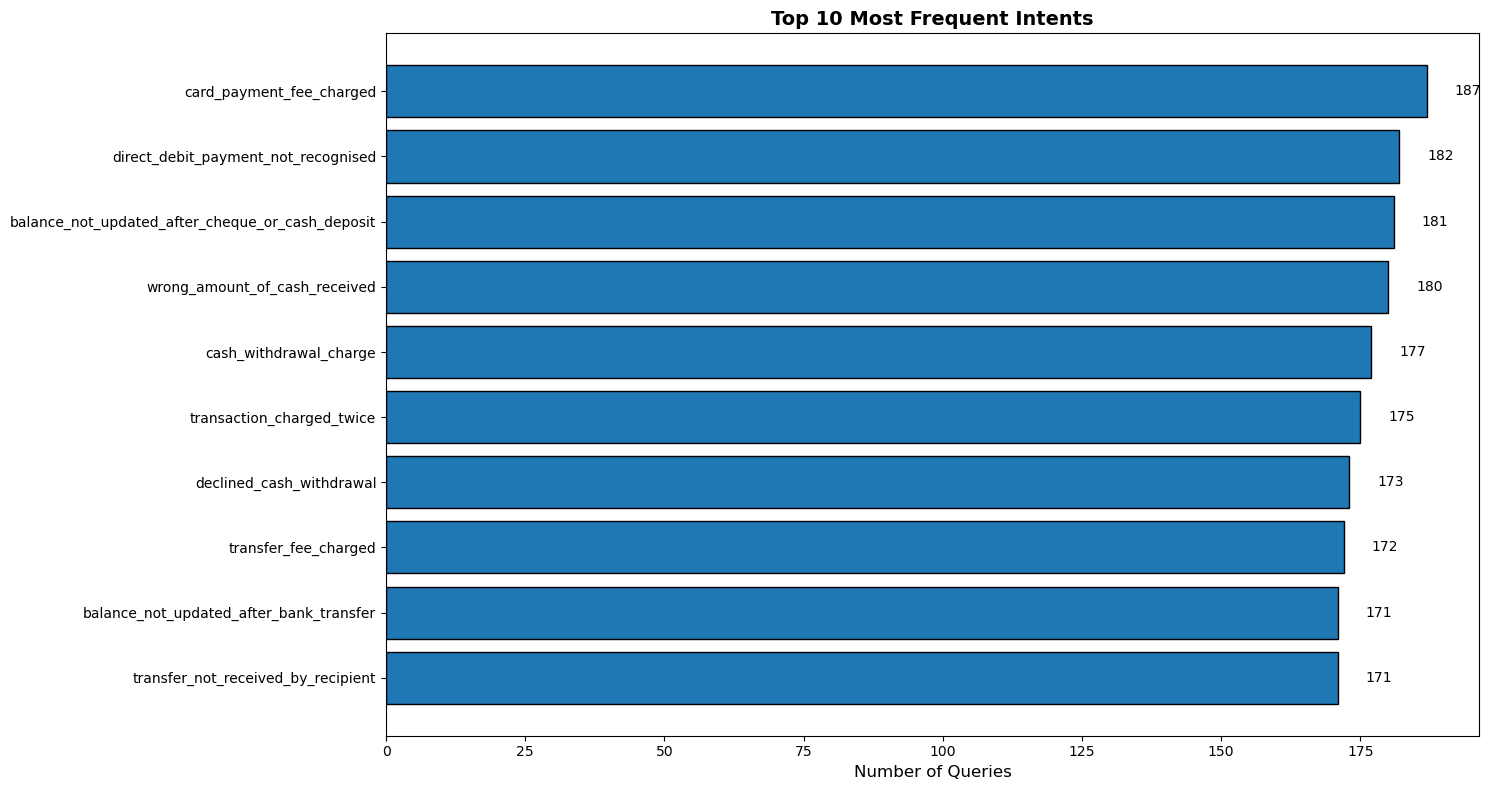

In [12]:
# Intent categories by frequency

plt.figure(figsize=(15, 8))
bars = plt.barh(category_counts.index, category_counts.values, edgecolor='black')
plt.gca().invert_yaxis()  # Highest counts on top
plt.xlabel("Number of Queries", fontsize=12)
plt.title("Top 10 Most Frequent Intents", fontsize=14, fontweight='bold')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
# Annotate each bar
for bar in bars:
    width = bar.get_width()
    plt.text(width + 5, bar.get_y() + bar.get_height() / 2,
             f'{int(width)}', va='center', fontsize=10)
plt.tight_layout()
plt.show();

#### **WordCloud of full training text**

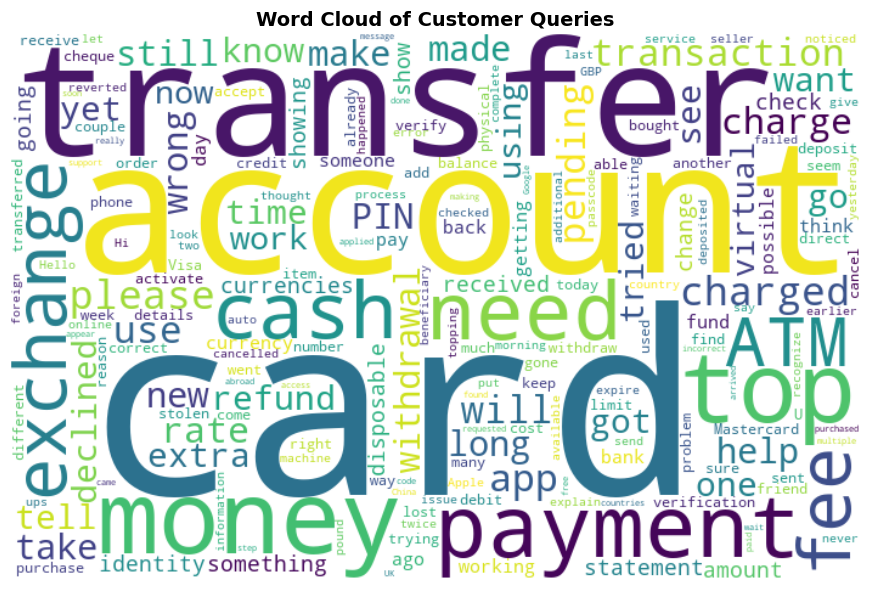

In [13]:
all_text = " ".join(train_df['text'].tolist())
wordcloud = WordCloud(
    width=700,
    height=450,
    background_color='white',
    max_words=200,
    collocations=False
).generate(all_text)

plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Customer Queries", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show();

## **Data Preprocessing**

In [14]:
def clean_text(text):

    # Convert to lowercase
    text = text.lower()
    
    # Remove punctuation and special characters
    text = re.sub(r'[^\w\s]', '', text)

    # Normalize whitespace
    text = re.sub(r'\s+', ' ', text)

    # remove any leading or trailing whitespace characters
    text = text.strip()

    return text

In [15]:
# Clean the text columns

train_df['clean_text'] = train_df['text'].apply(clean_text)
test_df['clean_text'] = test_df['text'].apply(clean_text)

# Sample cleaned text
train_df[['text','clean_text']].sample(3)

text  \
7218                                 why was i chargged   
3900             I'm having trouble proving my identity   
4420  How many transactions can I do with a disposab...   

                                             clean_text  
7218                                 why was i chargged  
3900              im having trouble proving my identity  
4420  how many transactions can i do with a disposab...

#### **Feature Extraction (TF-IDF)**

In [16]:
tfidf_vectorizer = TfidfVectorizer(
    ngram_range=(1, 3),  # Capture longer phrases that might be important
    min_df=2,            # Removes terms that appear in fewer than 2 documents
    max_df=0.95,         # Removes terms that appear in more than 95% of documents
    sublinear_tf=True    # Reduces the weight of terms that occur very frequently in a document
)

In [17]:
# Determining Target vector (y) and Feature Matrix (X)

X = tfidf_vectorizer.fit_transform(train_df['clean_text'])
y = train_df['category']

print("TF-IDF matrix feature shape:", X.shape)
print("Our Target Vector Shape is:", y.shape)

TF-IDF matrix feature shape: (10003, 21758)
Our Target Vector Shape is: (10003,)


#### **Train/Validation Split**

In [18]:
#performing train test split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify=y, test_size = 0.2)

#checking shapes of the both X_train and X_test sets
print("X_train:", X_train.shape, "X_test:", X_test.shape)

X_train: (8002, 21758) X_test: (2001, 21758)


## **MODELLING**

### **Linear SVC Model**

In [19]:
# Training LinearSVC Model

# Create Model
svc_model = LinearSVC(class_weight='balanced', random_state=42, max_iter=5000)

# Fit the Model
svc_model.fit(X_train, y_train)

# Predict
svc_prediction = svc_model.predict(X_test)

# Test Accuracy, precision, recall, f1 score
svc_accuracy = accuracy_score(y_test, svc_prediction)
svc_precision = precision_score(y_test, svc_prediction, average='macro')
svc_recall = recall_score(y_test, svc_prediction, average='macro')
svc_f1_score = f1_score(y_test, svc_prediction, average='macro')

print(f"SVC Model Accuracy: {svc_accuracy:.4f}")
print(f"SVC model Precision: {svc_precision:.4f}  (macro‐avg)")
print(f"SVC Model Recall: {svc_recall:.4f}  (macro‐avg)")
print(f"SVC F1 Score: {svc_f1_score:.4f}  (macro‐avg)");

SVC Model Accuracy: 0.8691
SVC model Precision: 0.8740  (macro‐avg)
SVC Model Recall: 0.8695  (macro‐avg)
SVC F1 Score: 0.8693  (macro‐avg)


In [20]:
print("Classification Report - LinearSVC")
print(classification_report(y_test, svc_prediction, zero_division=0));

Classification Report - LinearSVC
                                                  precision    recall  f1-score   support

                           Refund_not_showing_up       0.91      0.97      0.94        32
                                activate_my_card       0.97      0.97      0.97        32
                                       age_limit       1.00      0.95      0.98        22
                         apple_pay_or_google_pay       1.00      0.96      0.98        25
                                     atm_support       0.93      0.82      0.88        17
                                automatic_top_up       1.00      0.92      0.96        25
         balance_not_updated_after_bank_transfer       0.84      0.79      0.82        34
balance_not_updated_after_cheque_or_cash_deposit       0.89      0.92      0.90        36
                         beneficiary_not_allowed       0.84      0.84      0.84        31
                                 cancel_transfer       0.97      

### **Logistic Regression Model**

In [21]:
# Training Logistic Regression Model

# Create model
lr_model = LogisticRegression(random_state=42, max_iter=1000, class_weight="balanced")

# Fit model
lr_model.fit(X_train, y_train)

# Predict
lr_prediction = lr_model.predict(X_test)

# Test Accuracy, precision, recall, f1 score
lr_accuracy = accuracy_score(y_test, lr_prediction)
lr_precision = precision_score(y_test, lr_prediction, average='macro')
lr_recall = recall_score(y_test, lr_prediction, average='macro')
lr_f1_score = f1_score(y_test, lr_prediction, average='macro')

print(f"Logistic Regression Model Accuracy: {lr_accuracy:.4f}")
print(f"Logistic Regression model Precision: {lr_precision:.4f}")
print(f"Logistic Regression Model Recall: {lr_recall:.4f}")
print(f"Logistic Regression F1 Score: {lr_f1_score:.4f}");

Logistic Regression Model Accuracy: 0.8391
Logistic Regression model Precision: 0.8466
Logistic Regression Model Recall: 0.8445
Logistic Regression F1 Score: 0.8415


In [22]:
print("Classification Report - Logistic Regression")
print(classification_report(y_test, lr_prediction, zero_division=0));

Classification Report - Logistic Regression
                                                  precision    recall  f1-score   support

                           Refund_not_showing_up       0.97      0.94      0.95        32
                                activate_my_card       1.00      0.91      0.95        32
                                       age_limit       1.00      0.95      0.98        22
                         apple_pay_or_google_pay       1.00      0.96      0.98        25
                                     atm_support       0.88      0.88      0.88        17
                                automatic_top_up       0.95      0.84      0.89        25
         balance_not_updated_after_bank_transfer       0.79      0.68      0.73        34
balance_not_updated_after_cheque_or_cash_deposit       0.84      0.86      0.85        36
                         beneficiary_not_allowed       0.86      0.81      0.83        31
                                 cancel_transfer       

### **Naive Bayes Model**

In [23]:
# Training the Naive Bayes model

# Create Model
nb_model = MultinomialNB()

# Fit Model
nb_model.fit(X_train, y_train)

# Predict on test set
nb_predictions = nb_model.predict(X_test)

# Test Accuracy, precision, recall, f1 score
nb_accuracy = accuracy_score(y_test, nb_predictions)
nb_precision = precision_score(y_test, nb_predictions, average='macro')
nb_recall = recall_score(y_test, nb_predictions, average='macro')
nb_f1 = f1_score(y_test, nb_predictions, average='macro')

# Evaluation results
print(f"Naive Bayes Accuracy:         {nb_accuracy:.4f}")
print(f"Naive Bayes Precision:        {nb_precision:.4f}  (macro avg)")
print(f"Naive Bayes Recall:           {nb_recall:.4f}  (macro avg)")
print(f"Naive Bayes F1 Score:         {nb_f1:.4f}  (macro avg)\n")

Naive Bayes Accuracy:         0.7961
Naive Bayes Precision:        0.8227  (macro avg)
Naive Bayes Recall:           0.7673  (macro avg)
Naive Bayes F1 Score:         0.7746  (macro avg)



In [24]:
# Classification report
print("Classification Report:\n")
print(classification_report(y_test, nb_predictions, zero_division=0))

Classification Report:

                                                  precision    recall  f1-score   support

                           Refund_not_showing_up       0.93      0.84      0.89        32
                                activate_my_card       0.62      0.97      0.76        32
                                       age_limit       1.00      0.91      0.95        22
                         apple_pay_or_google_pay       0.86      1.00      0.93        25
                                     atm_support       0.77      0.59      0.67        17
                                automatic_top_up       0.96      0.88      0.92        25
         balance_not_updated_after_bank_transfer       0.80      0.71      0.75        34
balance_not_updated_after_cheque_or_cash_deposit       0.63      0.92      0.75        36
                         beneficiary_not_allowed       0.79      0.84      0.81        31
                                 cancel_transfer       0.85      0.94      